# BTVN 3

Vướng lượng tử & Các thuật toán truy vấn lượng tử

In [135]:
import numpy as np
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization import plot_bloch_multivector
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

In [136]:
# Hàm phụ trợ để in trạng thái đẹp hơn (dạng Dirac: a|00> + b|11>)
def format_state(state_vec):
    # Lấy dữ liệu từ điển
    data = state_vec.to_dict()
    terms = []
    for basis_state, amplitude in data.items():
        # Làm tròn số phức để bỏ qua sai số máy tính nhỏ (ví dụ 1e-16j)
        amp = np.round(amplitude, 3) 
        if abs(amp) > 0: # Chỉ in những trạng thái có xác suất > 0
            # Xử lý dấu + để in cho đẹp
            term_str = f"{amp}|{basis_state}>"
            terms.append(term_str)
    return "   ".join(terms)

## Bài 1

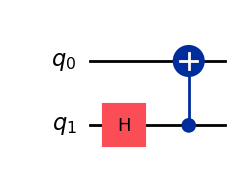

In [137]:
# Vẽ mạch lượng tử
qc = QuantumCircuit(2)
qc.h(1)
qc.cx(1,0)

qc.draw(output='mpl')

In [138]:
# Tính toán
inputs = ['00', '01', '10', '11']

for inp in inputs:
    qc = QuantumCircuit(2)
    
    # 1. Khởi tạo trạng thái đầu vào
    # Nếu bit là '1', ta dùng cổng X để lật |0> thành |1>
    if inp[0] == '1':
        qc.x(1)
    if inp[1] == '1':
        qc.x(0)
        
    # 2. Áp dụng mạch H + CNOT
    qc.h(1)      # H lên qubit 1
    qc.cx(1, 0)  # CNOT (control=1, target=0)
    
    # 3. Xem kết quả
    state = Statevector(qc)
    pretty_output = format_state(state)
    print(f"|{inp}>      | {pretty_output}")

|00>      | (0.707+0j)|00>   (0.707+0j)|11>
|01>      | (0.707+0j)|01>   (0.707+0j)|10>
|10>      | (0.707+0j)|00>   (-0.707+0j)|11>
|11>      | (0.707+0j)|01>   (-0.707+0j)|10>


**Nhận xét:** Mạch này chuyển cơ sở tính toán gồm các trạng thái tách được sang cơ sở Bell gồm các trạng thái vướng.

## Câu 2

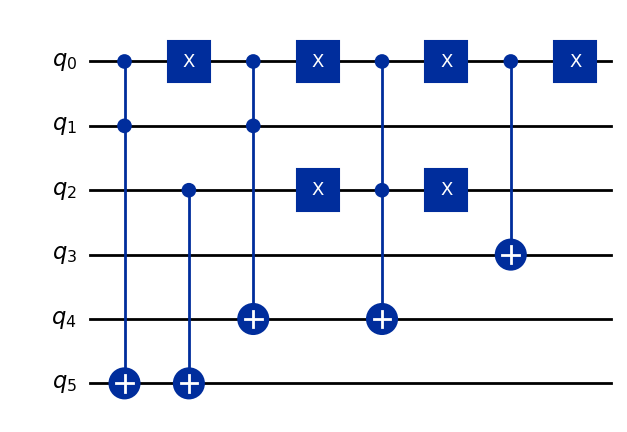

In [139]:
# 3 qubit đầu vào (0, 1, 2) và 3 qubit đầu ra (3, 4, 5)
qc = QuantumCircuit(6)

# 1. Tính F = AB XOR C trên qubit 5
qc.ccx(0, 1, 5)  # Toffoli(A, B, F) -> F = AB
qc.cx(2, 5)      # CNOT(C, F) -> F = AB XOR C

# 2. Tính E = (NOT A)B + A(NOT C) trên qubit 4
# Phần 1: (NOT A)B
qc.x(0)          # NOT A
qc.ccx(0, 1, 4)  # Toffoli(NOT A, B, E) -> E = (NOT A)B
qc.x(0)          # Quay lại A ban đầu

# Phần 2: A(NOT C)
qc.x(2)          # NOT C
qc.ccx(0, 2, 4)  # Toffoli(A, NOT C, E) -> E = (NOT A)B + A(NOT C)
qc.x(2)          # Quay lại C ban đầu

# 3. Tính D = NOT A trên qubit 3
qc.x(0)          # NOT A
qc.cx(0, 3)      # CNOT(A, D) -> D = NOT A
qc.x(0)          # Quay lại A ban đầu

# Vẽ mạch
qc.draw(output='mpl')

In [140]:
# Kiểm tra kết quả câu d
# Trạng thái đầu vào là |ψ>_in = 1/sqrt(3) (|000> + |100> + |111>)
desired_vector = np.zeros(2**6)
desired_vector[[0, 1, 7]] = 1/np.sqrt(3)
qc.initialize(desired_vector, range(6))

# Áp dụng mạch lượng tử đã xây dựng
# 1. Tính F = AB XOR C trên qubit 5
qc.ccx(0, 1, 5)  # Toffoli(A, B, F) -> F = AB
qc.cx(2, 5)      # CNOT(C, F) -> F = AB XOR C

# 2. Tính E = (NOT A)B + A(NOT C) trên qubit 4
# Phần 1: (NOT A)B
qc.x(0)          # NOT A
qc.ccx(0, 1, 4)  # Toffoli(NOT A, B, E) -> E = (NOT A)B
qc.x(0)          # Quay lại A ban đầu

# Phần 2: A(NOT C)
qc.x(2)          # NOT C
qc.ccx(0, 2, 4)  # Toffoli(A, NOT C, E) -> E = (NOT A)B + A(NOT C)
qc.x(2)          # Quay lại C ban đầu

# 3. Tính D = NOT A trên qubit 3
qc.x(0)          # NOT A
qc.cx(0, 3)      # CNOT(A, D) -> D = NOT A
qc.x(0)          # Quay lại A ban đầu

state = Statevector(qc)
pretty_output = format_state(state)
print(f"Trạng thái đầu ra |ψ>_out: | {pretty_output}")

Trạng thái đầu ra |ψ>_out: | (0.577+0j)|000111>   (0.577+0j)|001000>   (0.577+0j)|010001>


## Câu 3

Trạng thái cuối cùng của hệ 4 qubit: | (0.5+0j)|0000>   (0.5+0j)|0011>   (0.5+0j)|1100>   (0.5+0j)|1111>


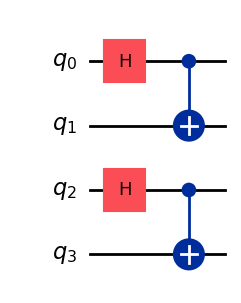

In [141]:
# 1. Khởi tạo mạch
qc = QuantumCircuit(4)

# 2. Tạo bản sao |Phi+> trên cặp qubit (q0, q1)
# Quy trình: H lên q0, sau đó CNOT(q0, q1)
qc.h(0)
qc.cx(0, 1)

# 3. Tạo bản sao |Phi+> trên cặp qubit (q2, q3)
# Quy trình: H lên q2, sau đó CNOT(q2, q3)
qc.h(2)
qc.cx(2, 3)

# 4. Kiểm tra kết quả
state = Statevector(qc)

pretty_output = format_state(state)
print(f"Trạng thái cuối cùng của hệ 4 qubit: | {pretty_output}")

qc.draw(output='mpl')

## Câu 5

In [142]:
# 1. Khởi tạo mạch 2 qubit
qc = QuantumCircuit(2)

# 2. Tạo trạng thái đầu vào |+>|+>
qc.h([0, 1])

# 3. Áp dụng Oracle pha Z_f cho hàm XOR
# Lý thuyết: (-1)^(x XOR y) = (-1)^x * (-1)^y => Cổng Z trên cả 2 qubit
qc.z(0)
qc.z(1)

# 4. Hiển thị kết quả
state = Statevector(qc)
pretty_output = format_state(state)
print(f"Trạng thái cuối cùng sau Oracle pha Z_f: | {pretty_output}")

Trạng thái cuối cùng sau Oracle pha Z_f: | (0.5+0j)|00>   (-0.5+0j)|01>   (-0.5+0j)|10>   (0.5+0j)|11>


## Câu 6

In [143]:
def deutsch_jozsa(oracle_type):
    # Khởi tạo mạch với 3 qubit
    # q0, q1: Input
    # q2: Ancilla (Qubit phụ trợ)
    qc = QuantumCircuit(3)
    
    # 1. Khởi tạo trạng thái:
    # Input |0> -> H -> |+>
    # Ancilla |0> -> X -> |1> -> H -> |->
    qc.x(2)          
    qc.h(range(3))   
    
    qc.barrier()
    
    # 2. Áp dụng Oracle (Hàm tiên tri)
    if oracle_type == 'f1': # Hàm Hằng (Constant = 1)
        # f(x) = 1 => Đảo bit ancilla (tương đương thêm dấu trừ toàn cục)
        qc.x(2) 
    elif oracle_type == 'f2': # Hàm Cân bằng (f(x) = x1)
        # f(x) = x1 => Cổng CNOT từ q1 sang q2 (Ancilla)
        qc.cx(1, 2)
        
    qc.barrier()
    
    # 3. Giao thoa (Interference)
    # Áp dụng cổng H lên các qubit input để tạo giao thoa
    qc.h([0, 1])
        
    # 4. Tính toán Vector trạng thái (Statevector)
    state = Statevector(qc)
    
    # 5. Lấy mẫu kết quả đo
    # Chỉ đo 2 qubit input (q0 và q1)
    counts = state.sample_counts(shots=1, qargs=[0, 1])
    
    # 6. Vẽ mạch
    display(qc.draw(output='mpl'))
    
    return counts

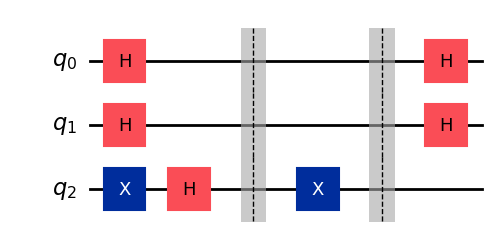

Kết quả đo f1 (Hàm Hằng):     {np.str_('00'): np.int64(1)}


In [144]:
# Trường hợp f1 (Hàm Hằng)
res_f1 = deutsch_jozsa('f1')
print(f"Kết quả đo f1 (Hàm Hằng):     {res_f1}")

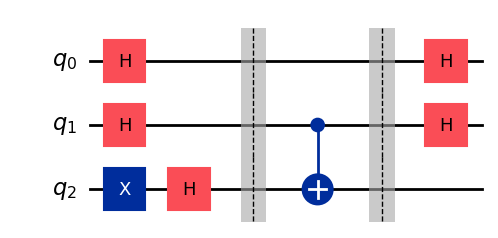

Kết quả đo f2 (Hàm Cân bằng): {np.str_('10'): np.int64(1)}


In [145]:
# Trường hợp f2 (Hàm Cân bằng)
res_f2 = deutsch_jozsa('f2')
print(f"Kết quả đo f2 (Hàm Cân bằng): {res_f2}")